# A friendly introduction to EasyTS

**Author:** Hannu Parviainen </br>
**Edited:** 11 August 2024

EasyTS is a Python package that aims to make exoplanet transmission spectroscopy as easy, fast, and robust as possible. The EasyTS transmission spectroscopy is based on Bayesian inference where all the spectroscopic transit light curves are modelled simultaneously. This approach is enabled by a specialized transit model that can model spectroscopic transit light curves tens of times faster than the  traditional transit models optimised to modelling transits in individual passbands, and the use of B-splines to model the wavelength-dependency of the stellar limb darkening parameters and planet-star-radius ratio. 

Here we go through the main concepts and theory behind the package, while the DSFSDFSDF shows how to use it for a transmission spectroscopy analysis.

In [6]:
%matplotlib inline

from numpy import array, ones, full, linspace, geomspace
from numpy.random import normal
from matplotlib.pyplot import subplots, setp

from exoiris import EasyTS, TSData

## Concepts

### Spectroscopic transit light curves

**A spectroscopic transit light curve** is a collection of photometric time series created from a spectroscopic time series. It can be represented as a two-dimensional array with wavelength on one axis and time on another. EasyTS uses `TSData` (Transmission Spectroscopy Data) class to encapsulate the light curves, which stores the spectroscopic light curves as `(n_wavelengths, n_exposures)` array. 

Let's create a mock `TSData` object that we'll use in this tutorial. Our data set consists of 200 light curves with 500 exposures covering wavelengths from 0.5 to 1.5 $\mu$m and time span from -0.1 to 0.1 days.

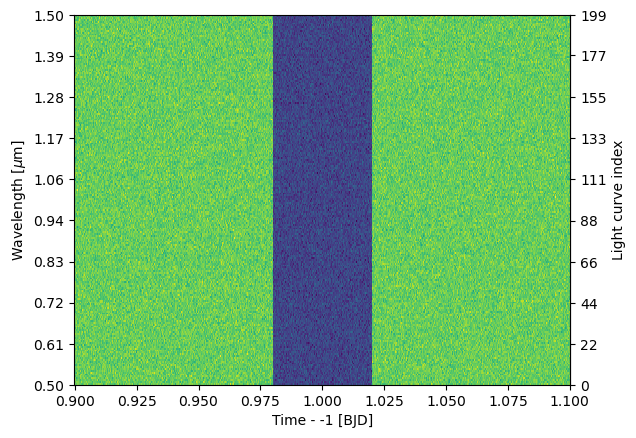

In [2]:
nwl, nexp = 200, 500

wavelength = linspace(0.5, 1.5, nwl)
time = linspace(-0.1, 0.1, nexp)
flux = normal(1.0, 1e-3, size=(nwl, nexp))
flux[:, 200:300] *= 0.99
ferr = full(flux.shape, 1e-3)

data = TSData(time, wavelength, flux, ferr)
data.plot();

### Spline represenation of limb darkening parameters and radius ratios

EasyTS is designed to infer the posterior transmission spectrum by modelling all spectroscopic light curves simultaneously. This is achieved through the utilisation of PyTransit's TSModel, a transit model specifically optimised for transmission spectroscopy. Unlike standard models, TSModel can process spectroscopic transit light curves at a significantly faster rate, making the simultaneous analysis of multiple light curves feasible.

However, while `TSModel` makes simultaneous modelling of spectroscopic transit light curves feasible, setting independent radius ratios and limb darkening parameters for each wavelength would lead to extremely large models. Especially with the JWST, where we generally have hundreds of spectroscopic elements. This is a problem because sampling the parameter space of a model with hundreds of free parameters with an MCMC sampler is challenging. One solution would be to bin the light curves along the wavelength to a lower resolution, but this would mean losing information we might want to keep.

EasyTS overcomes these challenges by using cubic interpolating B-splines to model wavelength-dependent parameters, such as the planet-to-star radius ratio and limb darkening coefficients. These splines are defined by a series of control points, or knots. At the beginning of the analysis, the locations of these knots along the wavelength axis are specified, though both their number and positions can be adjusted at any point during the analysis, including during MCMC sampling. The values at the knots are treated as free parameters within the model. *While the spectroscopic transit model is calculated for every wavelength bin in the dataset, the user has control over the number and distribution of the spline knots.*

This flexible approach allows users to optimise the resolution of the transmission spectrum to suit their specific scientific objectives. For instance, the knot density can be increased in regions with strong absorption features and decreased where fewer details are expected.

The resolution of the transmission spectrum estimated by EasyTS is determined by two key factors: 
1. the intrinsic wavelength resolution of the observational data, and
2. the number and positioning of the radius ratio spline knots.

The spectral resolution of the data defines the upper limit, beyond which further increases in model resolution may not yield additional information. For example, here is how a very-low resolution radius ratio model would look like. 

![k_knot_example.svg](k_knot_example.svg)

## Transmission spectroscopy with EasyTS

The aim of transmission spectroscopy is to estimate the effective size of a transiting exoplanet in different wavelengths (or, how the planet's effective size varies along the wavelength.) EasyTS does this using Bayesian inference modeling all the spectroscopic light curves simultaneously. 

A transmission spectroscopy analysis is done using the `EasyTS` class. The first step in setting up `EasyTS` is its initialisation.


### Initialisation

`EasyTS` initialisation requires, at minimum:
 
- `name`: a name for the analysis that will be used in the automatic savefiles.
- `ldmodel`: a limb darkening model. This can be any limb darkening model accepted by PyTransit's `RoadRunnerModel` as detailed later.
- `wavelength`: an 1D array containing the light curve wavelengths in $\mu$m.
- `time`: an 1D array containing the mid-exposure times in days.
- `fluxes`: a 2D array containing the normalised fluxes.
- `errors`: a 2D array containing the flux uncertainties.

Additionally, the initialiser can be given a set of optional arguments:

- `nk`: number of radius ratio knots (explained below).
- `nldc`: number of limb darkening knots (also explained below).
- `nthreads`: number of threads used in the model calculation.

### Transmission spectroscopy model parameterisation

The `EasyTS` transmission spectroscopy model parameters are grouped in three blocks

1. stellar density and planet's orbit,
2. stellar limb darkening,
3. radius ratio,
  
where the orbit is always defined by the first 6 parameters, the number of limb darkening parameters depends on the limb darkening model and number of limb darkening knots, and the number of radius ratios depends on the number of radius ratio knots.

The parameters defining the orbit are:
 - rho: stellar density [g/cm$^3$]
 - tc: transit center
 - p: orbital period [d]
 - b: impact parameter
 - secw: $\sqrt e \cos \omega$, where $e$ is the eccentricity and $\omega$ is the argument of periastron in radians, set to 0 by default
 - sesw: $\sqrt e \sin \omega$, where $e$ is the eccentricity and $\omega$ is the argument of periastron in radians, set to 0 by default

The first thing we need to do at the beginning of the analysis is to set priors for the transit center (`tc`) and orbital period (`p`). The stellar density (`rho`) and the impact parameter (`b`) are usually constrained well by our photometry, so we can leave the default uninformative priors. 

We set the priors using the `EasyTS.set_prior` method that takes the parameter name as its first argument, the prior as its second argument, and the prior parameters as optional additional arguments. The prior can be any object with `logpdf(x)` and `rvs(n)` methods, where `x` should be allowed to be either a scalar or an array and `n` an integer, but you can also use shortcut strings for normal priors (`NP`) and uniform priors (`UP`).

In [26]:
ts = EasyTS('Example', 'quadratic', data, nk=20, nldc=5)
ts.print_parameters()

  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf]
  1 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]
  2 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf]
  3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..      inf]
  4 |G| secw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  5 |G| sesw           N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  6 |G| ldc1_00.50000  U(a = 0, b = 1)                          [    -inf ..      inf]
  7 |G| ldc2_00.50000  U(a = 0, b = 1)                          [    -inf ..      inf]
  8 |G| ldc1_00.75000  U(a = 0, b = 1)                          [    -inf ..      inf]
  9 |G| ldc2_00.75000  U(a = 0, b = 1)                          [    -inf ..      inf]
 10 |G| ldc1_01.00000  U(a = 0, b = 1)                          [    -inf ..      inf]
 11 |G| ldc2_01.00000  U(a = 0, b = 1)     

The `EasyTS` initialiser has two optional integer parameters, `nk` and `nldc`, that define the radius ratio and limb darkening knot locations in wavelength. By default, EasyTS uses a linear spacing between the knots spanning the whole wavelength range. Both parameters are optional, and `nk` defaults to the number of wavelength bins in the data, and `nldc` defaults to 10. 

The intrinsinc data resolution, the radius ratio knots, and the limb darkening knots can be visualised using the `EaysyTS.plot_setup` method. Let's fits see how the default setup looks like for our mock data set.

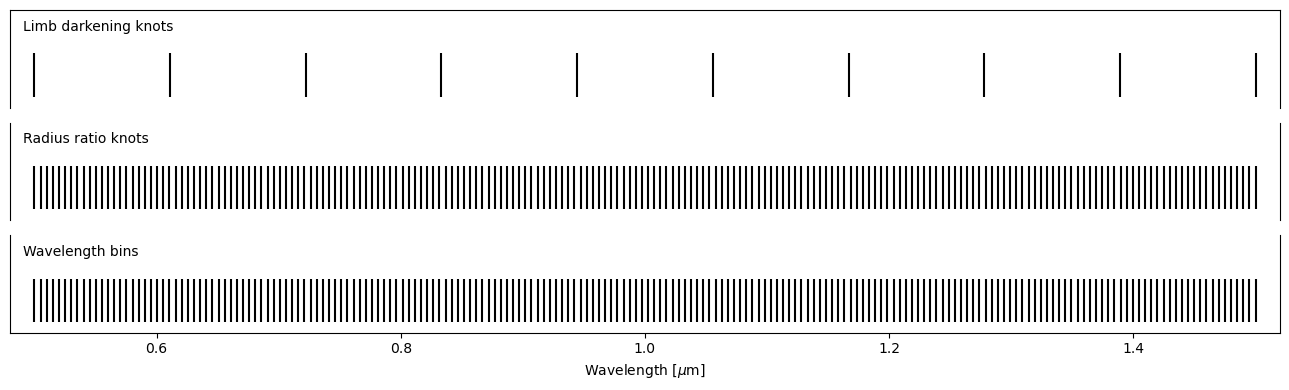

In [4]:
ts = EasyTS('Example', 'quadratic', data)
fig = ts.plot_setup();

As expected, we have 10 limb darkening knots and as many radius ratio knots as there are wavelength bins. Now, let's take a look at the setup if we reduce the number of radius ratio knots to 20 and the number of limb darkening knots to 5.

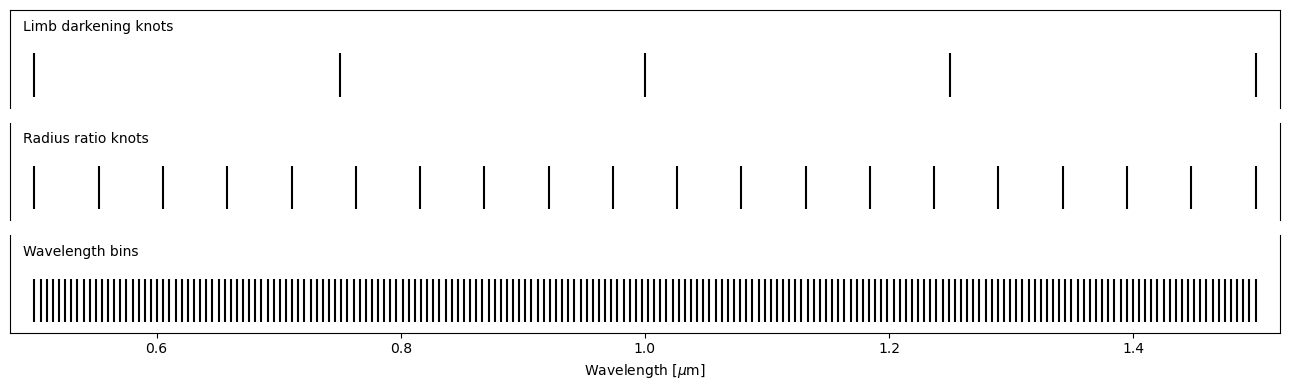

In [11]:
ts = EasyTS('Example', 'quadratic', data, nk=20, nldc=5)
ts.plot_setup();

This is again all as expected. However, in most cases we might not want to have a linearly spaced grid of knots, but we might prefer a logarithmic spacing in wavelength instead, or we might want to have a higher resolution near interesting lines, so let's see how to do this.

## Radius ratio knots

The radius ratio knots can be customised using the 
- `EasyTS.set_radius_ratio_knots(knot_wavelengths)` method, which replaces the current knot array with the given one, and the
- `EasyTS.add_radius_ratio_knots(knot_wavelengths)` method, which adds the given knot locations to the current knot array.

For example, if we'd want to use a logarithmic radius ratio knot spacing in wavelength, we can use the `EasyTS.set_radius_ratio_knots` method to override the current locations with ones created using `numpy.geomspace`

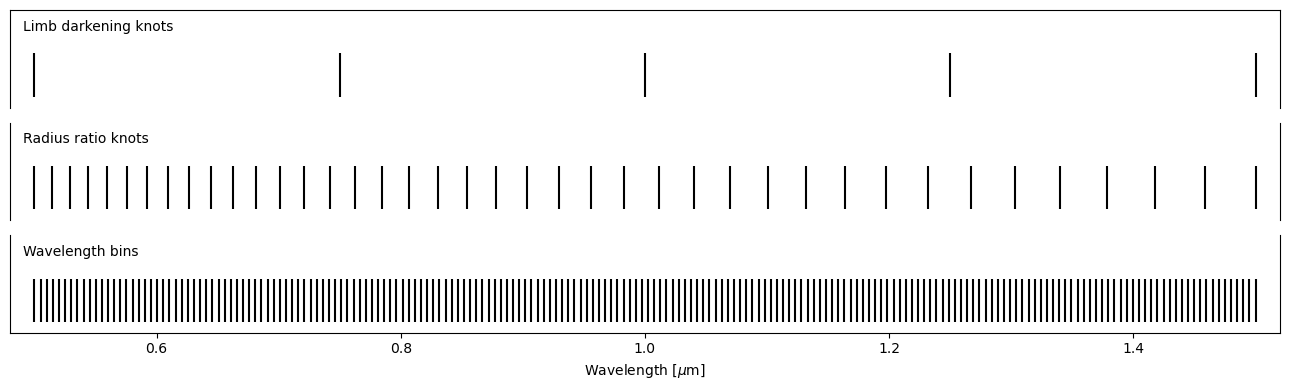

In [23]:
ts.set_radius_ratio_knots(geomspace(0.5, 1.5, 40))
ts.plot_setup();

Then, if we want to sample a certain wavelength region with a higher resolution, we can add knots where we want using the `EasyTS.add_radius_ratio_knots` method.

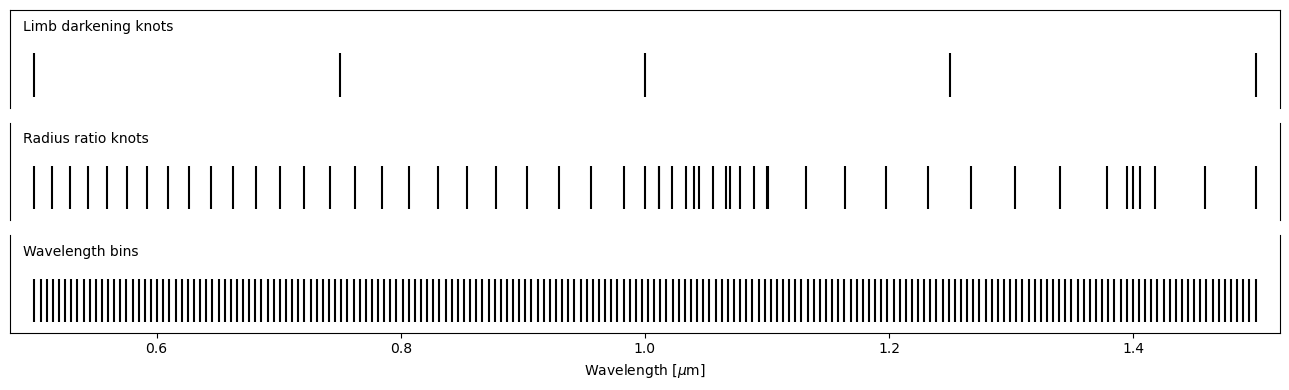

In [24]:
ts.add_radius_ratio_knots(linspace(1.0, 1.1, 10))
ts.add_radius_ratio_knots([1.395, 1.4, 1.405])
ts.plot_setup();

The number of radius ratio knots is stored in `EasyTS.nk` and the number of limb darkening knots is stored in `EasyTS.nldc`

## Limb darkening

The transmission spectroscopy transit model used in EasyTS, `pytransit.TSModel`, is based on PyTransit's RoadRunner transit model (`pytransit.RRModel`). The RoadRunner model is an advanced transit model that can use any radially symmetric function to model stellar limb darkening (while still being as fast as the analytical transit model assuming quadratic limb darkening) introduced in Parviainen (2020). 

Since `TSModel` is based on `RRModel`, it is as flexible as `RRModel` what comes to modeling the stellar limb darkening. The limb darkening model is defined by the `ldmodel` argument in `EasyTS` initialisation, where `ldmodel` can be 

- a string corresponding to one of the built-in limb darkening models supported by the `RRModel`,
- an object subclassing the `pytransit.models.ldmodel.LDModel` a limb darkening model class,
- a function that returns the stellar limb darkening profile as a function of $\mu$, or
- a tuple consisting of two functions, the first returning the limb darkening profile and the second its integral over the stellar disk. 

In the current example, we initialised EasyTS with the `cuadratic` limb darkening model. This leads to two limb darkening parameters being added to the model for each limb darkening knot.